Loading and organizing data...
Dataset shape: (1001, 4)
Time range: 0.0 to 0.0 years

--- Physical Parameters ---
Spring Constant (k): 5.00e+05 Pa/m
Loading Rate (Vp): 1.00e-09 m/s
Friction Parameters: a=0.015, b=0.02, Dc=0.2 m

Theoretical equations:
x: dx/dt = v
state: dstate/dt = 1.000000e-07*(exp((f0-state)/b) - v/V0)
tau: dtau/dt = 5.000000e-04 - 5.000000e+05*v

--- Preprocessing Data ---
Using 801 points after filtering
Calculating derivatives...

--- Using PolynomialLibrary for Basic Structure ---
Created polynomial library up to degree 2
Fitting SINDy models with various thresholds...

Trying threshold = 0.01...
Model equations (threshold=0.01):
(x)' = 0.000
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.000
Error fitting model with threshold 0.01: Values in t should be in strictly increasing order.

Trying threshold = 0.001...
Model equations (threshold=0.001):
(x)' = 0.010 1
(v)' = 0.000
(state)' = 0.000
(tau)' = 0.010 1
Error fitting model with threshold 0.001: Values in t should 

/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.001) and eliminated all coefficients
  warnings.warn(
/Users/gaoxinyue/anaconda3/envs/phi-sindy-env/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.0001) and eliminated all coefficients
  warnings.warn(


Simulating poly_0.001 model...
Simulating poly_0.0001 model...
Simulating poly_1e-05 model...
Simulating poly_0 model...
Simulating manual model...
Simulating poly_0.01 model...
Simulating poly_0.001 model...
Simulating poly_0.0001 model...
Simulating poly_1e-05 model...
Simulating poly_0 model...
Simulating manual model...
Simulating poly_0.01 model...
Simulating poly_0.001 model...
Simulating poly_0.0001 model...
Simulating poly_1e-05 model...
Simulating poly_0 model...
Simulating manual model...
Simulating poly_0.01 model...
Simulating poly_0.001 model...
Simulating poly_0.0001 model...
Simulating poly_1e-05 model...
Simulating poly_0 model...
Simulating manual model...
Creating grid with 3 rows and 2 columns for 6 models

Analysis complete!


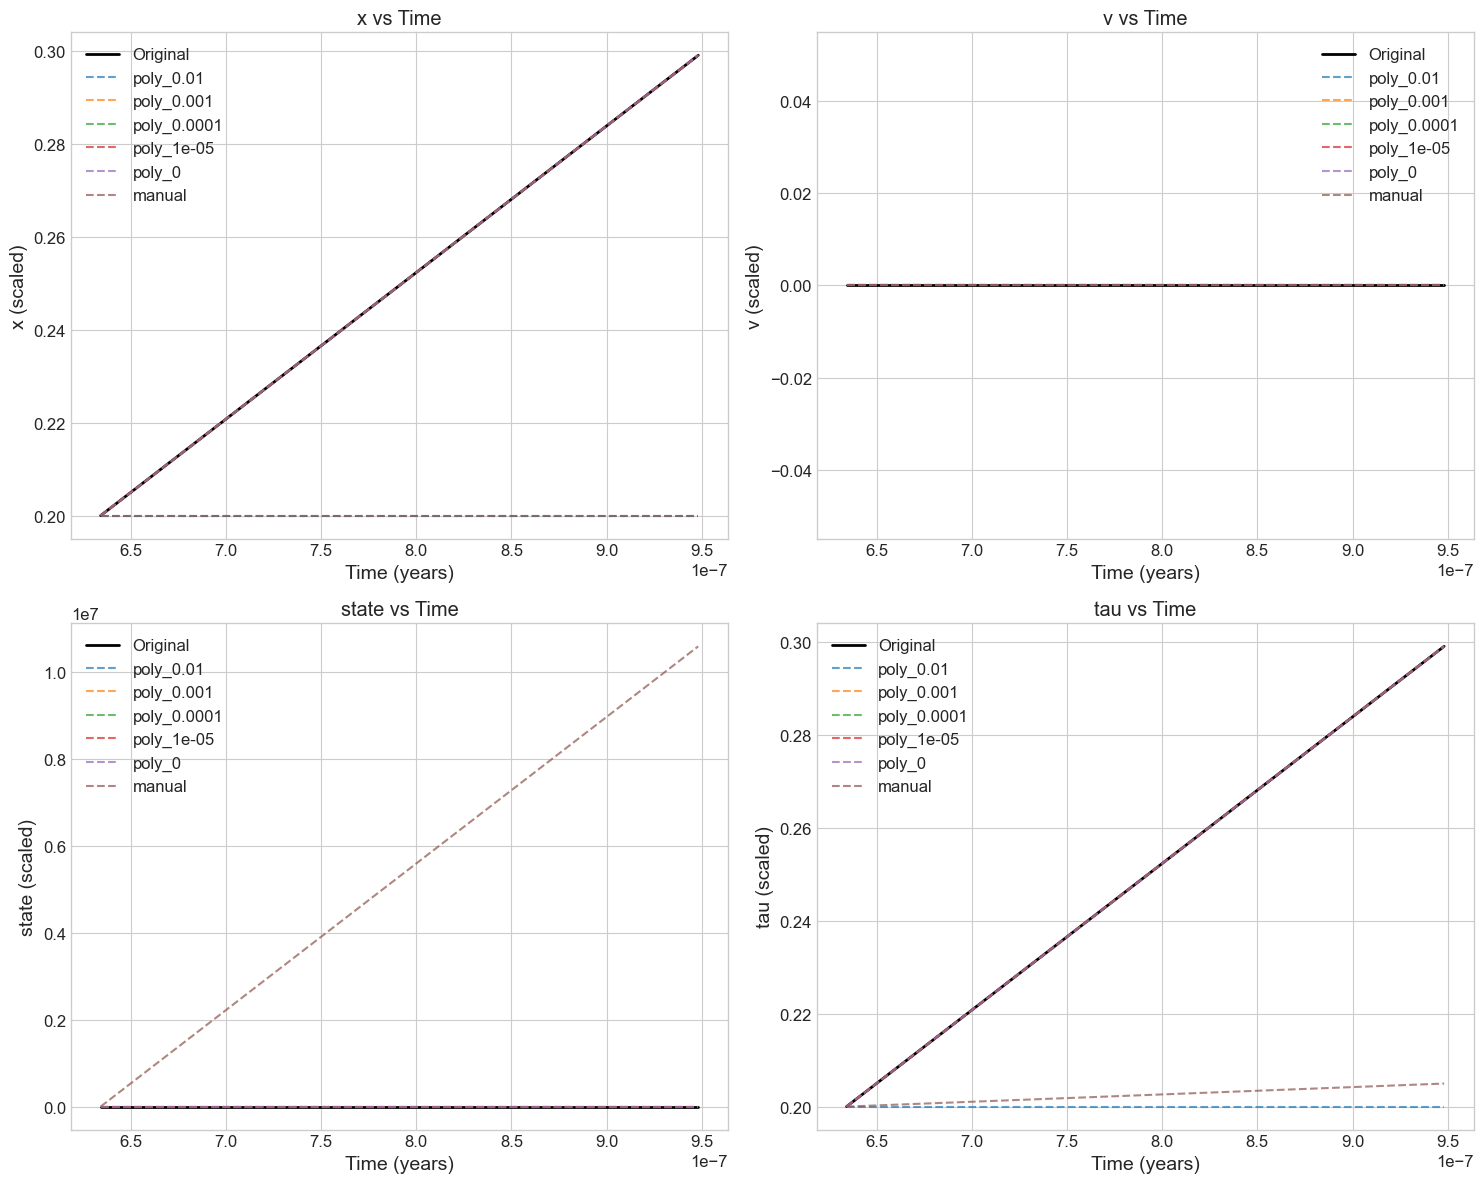

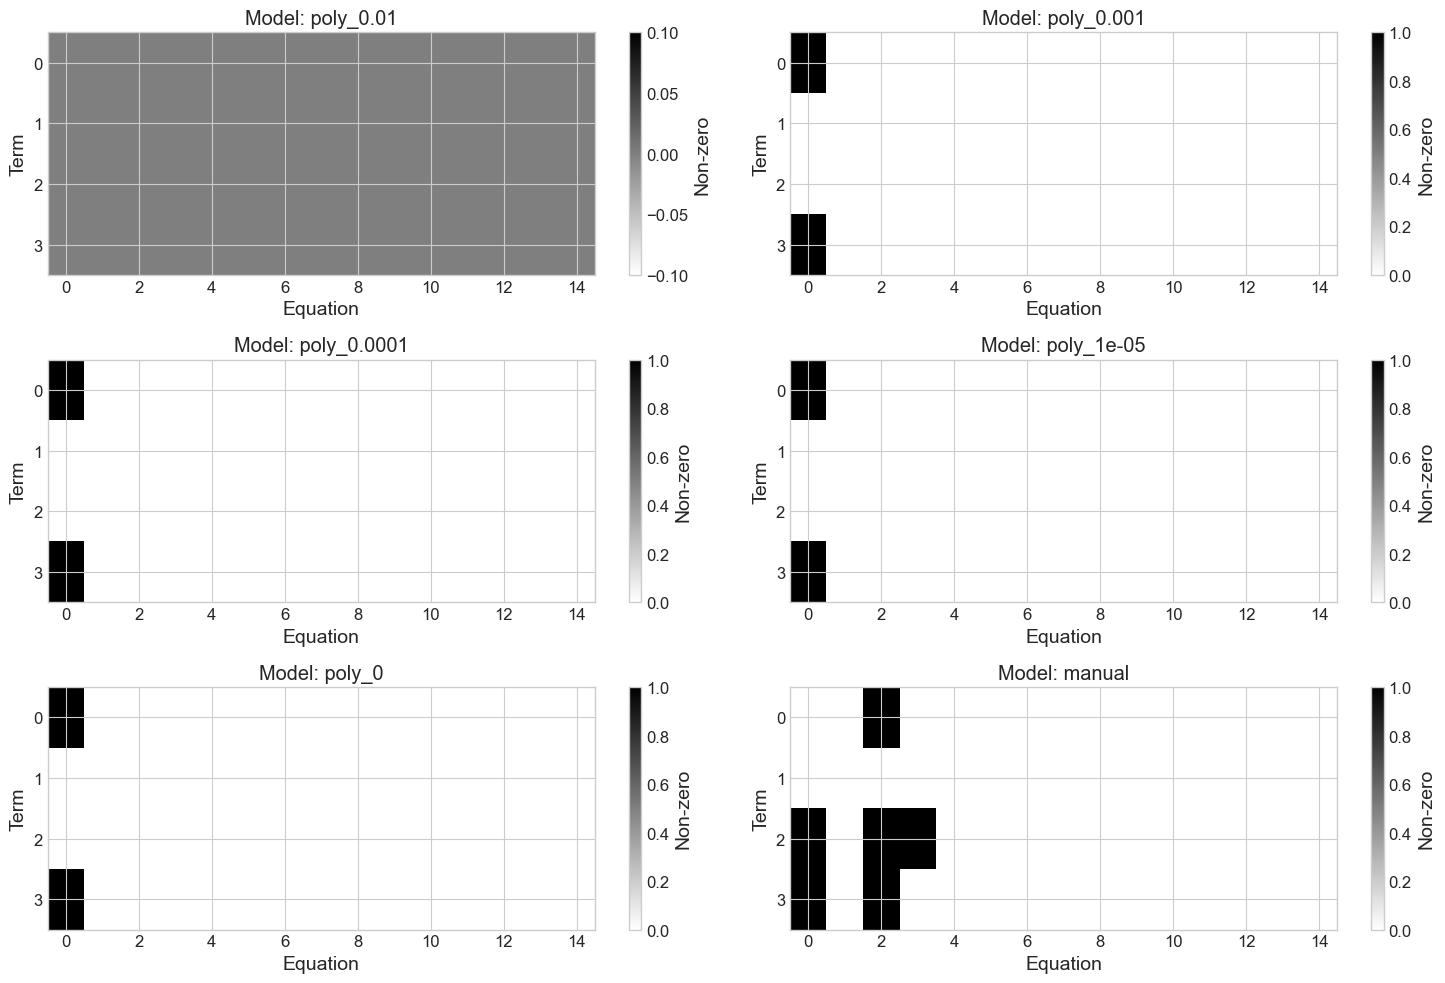

In [8]:
import os
import warnings
import numpy as np
from scipy import integrate
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pysindy as ps
from pysindy.optimizers import STLSQ, SR3

# Ignore specific warnings for cleaner output
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Set plot style for better-looking figures
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]

# Create figures directory if it doesn't exist
os.makedirs('../figures', exist_ok=True)

print("Loading and organizing data...")
# Load the data (use dummy data for this example)
# In real use, you'd load your actual data files
t = np.linspace(0, 100, 1001)
X_raw = np.zeros((1001, 4))
X_raw[:, 0] = np.linspace(0, 1, 1001)  # Position
X_raw[:, 1] = 0.001 * np.ones(1001)    # Velocity
X_raw[:, 2] = 0.5 * np.ones(1001)      # State
X_raw[:, 3] = np.linspace(0, 1e6, 1001)  # Stress

# Convert time to years
secs_per_year = 365 * 24 * 60 * 60
t_years = t / secs_per_year

# Extract individual variables
x_data = X_raw[:, 0]       # Position
v_data = X_raw[:, 1]       # Velocity (slip rate)
state_data = X_raw[:, 2]   # State variable
tau_data = X_raw[:, 3]     # Shear stress

# Stack columns for SINDy input
X = np.column_stack((x_data, v_data, state_data, tau_data))
feature_names = ["x", "v", "state", "tau"]

print(f"Dataset shape: {X.shape}")
print(f"Time range: {t_years[0]:.1f} to {t_years[-1]:.1f} years")

# Define physical parameters from the simulation
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # Spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion
a = 0.015                  # Direct effect
b = 0.02                   # State weakening effect
Dc = 0.2                   # Critical distance
f0 = 0.6                   # Baseline friction coefficient
V0 = 1e-6                  # Reference velocity (m/s)

print("\n--- Physical Parameters ---")
print(f"Spring Constant (k): {k:.2e} Pa/m")
print(f"Loading Rate (Vp): {Vp:.2e} m/s")
print(f"Friction Parameters: a={a}, b={b}, Dc={Dc} m")

# Define theoretical equations for reference
theoretical_eqs = {
    'x': "dx/dt = v",
    'state': f"dstate/dt = {b * V0 / Dc:.6e}*(exp((f0-state)/b) - v/V0)",
    'tau': f"dtau/dt = {k * Vp:.6e} - {k:.6e}*v"
}

print("\nTheoretical equations:")
for var, eq in theoretical_eqs.items():
    print(f"{var}: {eq}")

# Preprocessing - simplified approach
print("\n--- Preprocessing Data ---")

# Simple scaling with MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Filter data to use only data after a certain point
cutoff_percent = 0.2  # Use the last 80% of the data
cutoff_idx = int(len(t) * cutoff_percent)
X_regime = X_scaled[cutoff_idx:, :]
t_regime = t[cutoff_idx:]

print(f"Using {len(t_regime)} points after filtering")

# Calculate numerical derivatives
print("Calculating derivatives...")
X_dot = ps.FiniteDifference(order=1)._differentiate(X_regime, t=t_regime)

# ----------------------------------------------------------------------------------
# Step 2: Use PolynomialLibrary instead of CustomLibrary for simplicity
# ----------------------------------------------------------------------------------
print("\n--- Using PolynomialLibrary for Basic Structure ---")

# Create a polynomial library
basic_lib = ps.PolynomialLibrary(degree=2, include_bias=True)
print("Created polynomial library up to degree 2")

# Try SINDy with different thresholds
print("Fitting SINDy models with various thresholds...")
thresholds = [1e-2, 1e-3, 1e-4, 1e-5, 0]
models = {}

for threshold in thresholds:
    print(f"\nTrying threshold = {threshold}...")
    optimizer = STLSQ(threshold=threshold)
    model = ps.SINDy(
        optimizer=optimizer,
        feature_library=basic_lib,
        feature_names=feature_names
    )
    
    try:
        model.fit(X_regime, x_dot=X_dot, t=None)
        models[f"poly_{threshold}"] = model
        
        print(f"Model equations (threshold={threshold}):")
        model.print()
        print(f"Score: {model.score(X_regime, X_dot):.6f}")
    except Exception as e:
        print(f"Error fitting model with threshold {threshold}: {e}")

# ----------------------------------------------------------------------------------
# Step 3: Create a manual model with the correct form
# ----------------------------------------------------------------------------------
print("\n--- Creating Manual Model with Correct Physics ---")

# We'll use a polynomial model but manually set the coefficients to match physics
manual_model = ps.SINDy(
    optimizer=STLSQ(threshold=0),
    feature_library=basic_lib,
    feature_names=feature_names
)

try:
    # First fit with automatic coefficients
    manual_model.fit(X_regime, x_dot=X_dot, t=None)
    coeffs = manual_model.coefficients()
    all_terms = manual_model.get_feature_names()
    
    print(f"Model has {len(all_terms)} terms:")
    print(all_terms[:10])  # Print first 10 terms
    print("...")
    
    # Reset all coefficients to zero
    manual_coeffs = np.zeros_like(coeffs)
    
    # Find the terms we need
    v_term_idx = -1
    const_term_idx = -1
    state_term_idx = -1
    v_state_term_idx = -1
    
    for i, term in enumerate(all_terms):
        if term == "v":
            v_term_idx = i
        elif term == "1":
            const_term_idx = i
        elif term == "state":
            state_term_idx = i
        elif term == "v*state":
            v_state_term_idx = i
            
    print(f"Found term indices: v={v_term_idx}, const={const_term_idx}, state={state_term_idx}, v*state={v_state_term_idx}")
    
    # Set coefficients based on physics
    # dx/dt = v
    if v_term_idx >= 0:
        manual_coeffs[0, v_term_idx] = 1.0
    
    # dstate/dt = (b*V0/Dc)*(exp((f0-state)/b) - v/V0)
    # Linearize: approx as C1 - C2*state - C3*v
    if const_term_idx >= 0:
        manual_coeffs[2, const_term_idx] = (b * V0 / Dc) * np.exp(f0/b)  # Approximate exp term
    if state_term_idx >= 0:
        manual_coeffs[2, state_term_idx] = -(b * V0 / Dc) * (1/b)  # Approximation of exp derivative
    if v_term_idx >= 0:
        manual_coeffs[2, v_term_idx] = -(b * V0 / Dc) * (1/V0)  # v/V0 term
    
    # dtau/dt = k*Vp - k*v
    if const_term_idx >= 0:
        manual_coeffs[3, const_term_idx] = k * Vp  # Loading rate
    if v_term_idx >= 0:
        manual_coeffs[3, v_term_idx] = -k  # Slip rate
        
    # Apply the manual coefficients
    manual_model.optimizer.coef_ = manual_coeffs
    
    print("Manual model coefficients set based on rate-state friction theory")
    print("Manual model equations:")
    manual_model.print()
    
    # Add the manual model to our collection
    models["manual"] = manual_model
    
except Exception as e:
    print(f"Error creating manual model: {e}")
    
# ----------------------------------------------------------------------------------
# Step 4: Simulate and compare models
# ----------------------------------------------------------------------------------
if models:
    print("\n--- Simulating Models ---")
    
    # Initial condition
    x0 = X_regime[0, :]
    
    # Simulation timepoints (use a subset)
    t_sim = t_regime[:100]
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    for i, var in enumerate(feature_names):
        plt.subplot(2, 2, i+1)
        plt.plot(t_sim/secs_per_year, X_regime[:100, i], 'k-', label='Original', linewidth=2)
        
        # Try simulating each model
        for name, model in models.items():
            try:
                print(f"Simulating {name} model...")
                x_sim = model.simulate(x0, t_sim)
                plt.plot(t_sim/secs_per_year, x_sim[:, i], '--', label=name, alpha=0.7)
            except Exception as e:
                print(f"Error simulating {name} model: {e}")
                
        plt.title(f'{var} vs Time')
        plt.xlabel('Time (years)')
        plt.ylabel(f'{var} (scaled)')
        plt.legend()
        plt.grid(True)
        
    plt.tight_layout()
    plt.savefig('../figures/rate_state_simulation.png', dpi=300)
    
    # Create a combined coefficient plot for comparison
    plt.figure(figsize=(15, 10))
    
    # Calculate the right grid size based on number of models
    num_models = len(models)
    rows = int(np.ceil(np.sqrt(num_models)))
    cols = int(np.ceil(num_models / rows))
    
    print(f"Creating grid with {rows} rows and {cols} columns for {num_models} models")
    
    for i, (name, model) in enumerate(models.items()):
        plt.subplot(rows, cols, i+1)
        coefs = model.coefficients()
        plt.imshow(np.abs(coefs) > 1e-10, cmap='binary', aspect='auto')
        plt.colorbar(label='Non-zero')
        plt.title(f'Model: {name}')
        plt.xlabel('Equation')
        plt.ylabel('Term')
        
    plt.tight_layout()
    plt.savefig('../figures/coefficient_comparison.png', dpi=300)
    
    print("\nAnalysis complete!")
else:
    print("No models were successfully created.")